In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from highlight_text import fig_text, ax_text
from drawarrow import fig_arrow, ax_arrow
from pyfonts import load_google_font
import warnings
warnings.filterwarnings("ignore")

In [2]:
food_security = pd.read_csv("https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-10-14/food_security.csv", encoding="latin-1")

In [3]:
food_security.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171232 entries, 0 to 171231
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Year_Start  171232 non-null  int64  
 1   Year_End    171232 non-null  int64  
 2   Area        171232 non-null  object 
 3   Item        171232 non-null  object 
 4   Unit        171232 non-null  object 
 5   Value       156983 non-null  float64
 6   CI_Lower    24235 non-null   float64
 7   CI_Upper    24235 non-null   float64
 8   Flag        171232 non-null  object 
 9   Note        14664 non-null   object 
dtypes: float64(3), int64(2), object(5)
memory usage: 13.1+ MB


In [4]:
food_security.head(2)

,Year_Start,Year_End,Area,Item,Unit,Value,CI_Lower,CI_Upper,Flag,Note
0,2005,2007,Afghanistan,Average dietary energy supply adequacy (percen...,%,97.0,NaN,NaN,Estimated value,NaN
1,2006,2008,Afghanistan,Average dietary energy supply adequacy (percen...,%,99.0,NaN,NaN,Estimated value,NaN


In [5]:
url = "https://raw.githubusercontent.com/JosephBARBIERDARNAL/data-matplotlib-journey/refs/heads/main/world/world.geojson"
world = gpd.read_file(url)
world = world[world["continent"] != "Antarctica"]
# Reproject to Robinson projection
world = world.to_crs("ESRI:54030")  # Units in meters 

In [6]:
world.head(2)

,name,continent,code_sov,code_adm,geometry
0,Costa Rica,North America,CRI,CRI,"POLYGON ((-7765577.595 1023116.582, -7802508.3..."
1,Nicaragua,North America,NIC,NIC,"POLYGON ((-7860677.966 1169921.817, -7884702.0..."


In [7]:
# Check what countries are in world data but not in food_security data
set1 = set(food_security["Area"])
set2 = set(world["name"])
print(set2-set1)

{'Kosovo', 'Netherlands', 'Laos', 'United Kingdom', 'North Korea', 'Taiwan', 'Tanzania', 'W. Sahara', 'Iran', 'Turkey', 'Vietnam', 'Venezuela', 'Dominican Rep.', 'eSwatini', 'Russia', 'South Korea', 'Falkland Is.', 'Moldova', 'Fr. S. Antarctic Lands', 'Bosnia and Herz.', "Côte d'Ivoire", 'Solomon Is.', 'Dem. Rep. Congo', 'Eq. Guinea', 'Somaliland', 'Syria', 'S. Sudan', 'Brunei', 'Central African Rep.', 'Bolivia', 'N. Cyprus'}


In [8]:
# Create new area column and replace country names 
food_security["area"] = food_security["Area"]
food_security["area"] = food_security["Area"].replace({"Bolivia (Plurinational State of)": "Bolivia",
                                                       "Bosnia and Herzegovina": "Bosnia and Herz.",
                                                       "Brunei Darussalam": "Brunei",
                                                       "Central African Republic": "Central African Rep.",
                                                       "Democratic Republic of the Congo": "Republic of the Congo",
                                                       "Dominican Republic": "Dominican Rep.",
                                                       "Eswatini": "eSwatini",
                                                       "Equatorial Guinea": "Eq. Guinea",
                                                       "Iran (Islamic Republic of)": "Iran",
                                                       "Lao People's Democratic Republic": "Laos",
                                                       "Republic of Moldova": "Moldova",
                                                       "Cyprus": "N. Cyprus",
                                                       "Netherlands (Kingdom of the)": "Netherlands",
                                                       "Democratic People's Republic of Korea": "North Korea",
                                                       "Russian Federation": "Russia",
                                                       "South Sudan": "S. Sudan",
                                                       "Solomon Islands": "Solomon Is.",
                                                       "Somalia": "Somaliland",
                                                       "Republic of Korea": "South Korea",
                                                       "Syrian Arab Republic": "Syria",
                                                       "China, Taiwan Province of": "Taiwan",
                                                       "United Republic of Tanzania": "Tanzania",
                                                       "Türkiye": "Turkey",
                                                       "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                                                       "Venezuela (Bolivarian Republic of)": "Venezuela",
                                                       "Viet Nam": "Vietnam"})  

In [9]:
# Filter dataframe for items and year
items = ["Percentage of children under 5 years of age who are stunted (modelled estimates) (percent)",
         "Percentage of children under 5 years of age who are overweight (modelled estimates) (percent)"]
filtered_df = food_security[(food_security["Item"].isin(items)) & (food_security["Year_Start"] == 2024)]

In [10]:
# Reshape data from long to wide
pivoted_df = pd.pivot(filtered_df, index=["Year_Start", "Year_End", "area"], columns="Item", values="Value")
df=pivoted_df.reset_index()

In [11]:
# Rename columns
df.rename(columns={"Percentage of children under 5 years of age who are overweight (modelled estimates) (percent)": "overweight",
                   "Percentage of children under 5 years of age who are stunted (modelled estimates) (percent)": "stunted"}, inplace=True)

In [12]:
# Select relevant columns
df = df[["overweight", "stunted", "area"]]

In [13]:
# Fill missing values with 0
df["overweight"] = df["overweight"].fillna(0)
df["stunted"] = df["stunted"].fillna(0)

In [14]:
# Merge dataframes
merged_df = world.merge(df, left_on="name", right_on="area",  how="right").reset_index()

In [15]:
# Select relevant columns
merged_df = merged_df[["area", "geometry", "overweight", "stunted"]]

In [16]:
# Function to create two half circles around a center point
def make_half_circles(center, radius_left, radius_right):
    cx, cy = center.x, center.y

    # Full circles
    circle_left = Point(cx, cy).buffer(radius_left)
    circle_right = Point(cx, cy).buffer(radius_right)

    # Define half plane polygons that cut the circle (large rectangles relative to circle radius)
    # Left side: x <= cx
    left_half_plane = Polygon([
        (cx, cy - 2*radius_left),
        (cx, cy + 2*radius_left),
        (cx - 2*radius_left, cy + 2*radius_left),
        (cx - 2*radius_left, cy - 2*radius_left)
    ])

    # Right side: x >= cx
    right_half_plane = Polygon([
        (cx, cy - 2*radius_right),
        (cx, cy + 2*radius_right),
        (cx + 2*radius_right, cy + 2*radius_right),
        (cx + 2*radius_right, cy - 2*radius_right)
    ])

    # Intersect circle with the half planes (rectangles)
    half_left = circle_left.intersection(left_half_plane)
    half_right = circle_right.intersection(right_half_plane)

    return half_left, half_right

In [17]:
# Create geometries
half_geoms = []
for i, row in merged_df.iterrows():
    if row.geometry is None:
        continue  # Skip rows without geometry
    centroid = row.geometry.centroid
    h1, h2 = make_half_circles(
        centroid,
        radius_left=row["overweight"] * 10000,   # Scale (meters)
        radius_right=row["stunted"] * 10000
    )
    half_geoms.append((h1, h2))

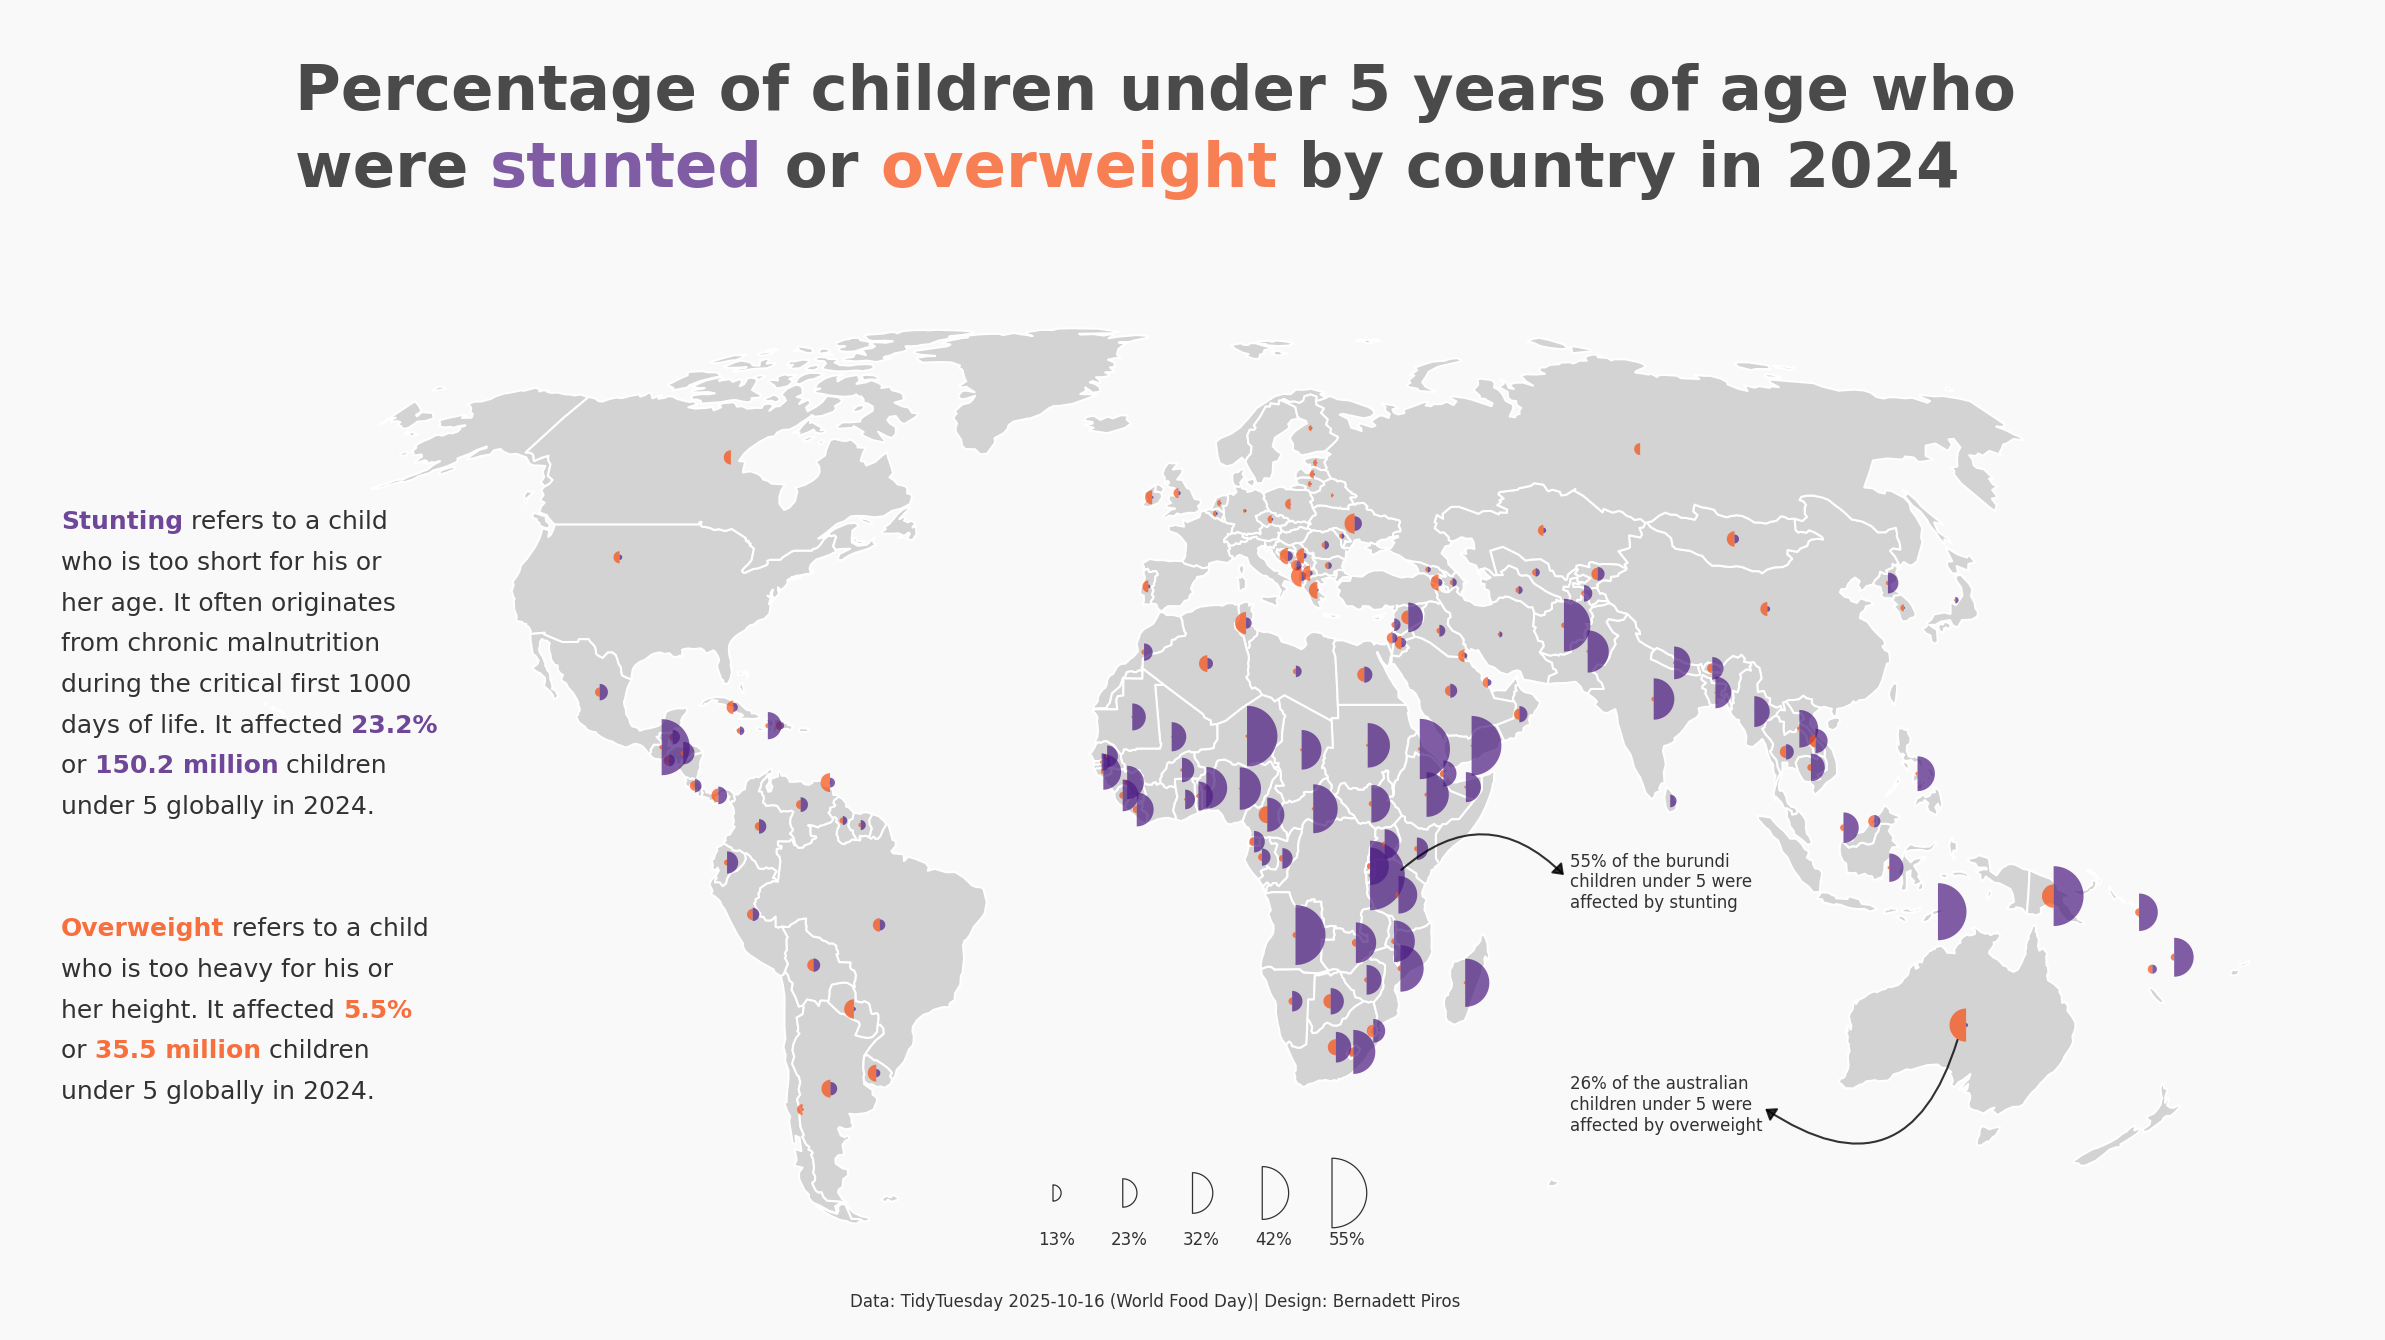

In [18]:
# Plot the world 
fig, ax = plt.subplots(figsize=(10, 8), facecolor="#f9f9f9", dpi=300)
world.plot(ax=ax, color="lightgrey", edgecolor="white", lw=0.5)

# Plot the half circles
for (left, right) in half_geoms:
    gpd.GeoSeries(left).plot(ax=ax, color="#F74C0D", alpha=0.7)
    gpd.GeoSeries(right).plot(ax=ax, color="#4B1A81", alpha=0.7)

ax.axis("off")

# Get axis limits
xmin, xmax, ymin, ymax = plt.axis()

## Legend
countries = ["Oman", "Indonesia", "Zambia", "Afghanistan", "Burundi"]
# Calculate horizontal positions for the legend
num = len(countries)
x_positions = list(np.linspace(xmin * 0.12, xmax * 0.12, num))  # Spread across approx. 12% in the middle
y_position = ymin + 1200000  # A little above the bottom of the map

centers = [Point(x, y_position) for x in x_positions]

# Scaling for the legend
max_val = merged_df["stunted"].max()
scaling= 10000

# Subset of values for the legend
df_subset = merged_df[merged_df["area"].isin(countries)]
df_subset = df_subset.sort_values(by="stunted")

# Create half circles for the legend
half_circles = []
for c, (i, row) in zip(centers, df_subset.iterrows()):
    i, right_half = make_half_circles(c, row["stunted"] * scaling, row["stunted"] * scaling)
    half_circles.append((right_half, row["stunted"]))

# Plot half circles for the legend
for geom, val in half_circles:
    gpd.GeoSeries([geom]).plot(ax=ax, color="none", edgecolor="black", alpha=0.8, lw=0.3)
    ax.text(
        geom.centroid.x, geom.centroid.y - 600000, f"{val:.0f}%",
        ha="center", va="top", fontsize=4, color="black", alpha=0.8
    )

## Text and arrow annotations
# Burundi
ax_arrow(
   tail_position=(3224167, -361214),
   head_position=(6000000, -450000),
   color="black",
   alpha=0.8,
   width=0.5,
   head_width=1.5,
   head_length=2,
   radius=-0.5,
   ax=ax
)

ax.text(6000000, -460000, "55% of the burundi\nchildren under 5 were\naffected by stunting", size=4, alpha=0.8, va="center")

# Australia
ax_arrow(
   tail_position=(12205313, -2851305),
   head_position=(9000000, -4000000),
   color="black",
   alpha=0.8,
   width=0.5,
   head_width=1.5,
   head_length=2,
   radius=-0.7,
   ax=ax
)

ax.text(6000000, -4000000, "26% of the australian\nchildren under 5 were\naffected by overweight", size=4, alpha=0.8, va="center")

# Texts
ax_text(
    -18000000, 3000000, 
    s="<Stunting> refers to a child\nwho is too short for his or\nher age. It often originates\nfrom chronic malnutrition\nduring the critical first 1000\ndays of life. It affected <23.2%>\nor <150.2 million> children\nunder 5 globally in 2024.",
    size=6, alpha=0.8, va="center",
    highlight_textprops=[
        {"color": "#4B1A81", "weight": "bold"},  
        {"color": "#4B1A81", "weight": "bold"},  
        {"color": "#4B1A81", "weight": "bold"},  
    ],
    ax=ax
)

ax_text(
    -18000000, -2500000, 
    s="<Overweight> refers to a child\nwho is too heavy for his or\nher height. It affected <5.5%>\nor <35.5 million> children\nunder 5 globally in 2024.",
    size=6, alpha=0.8, va="center",
    highlight_textprops=[
        {"color": "#F74C0D", "weight": "bold"},  
        {"color": "#F74C0D", "weight": "bold"},  
        {"color": "#F74C0D", "weight": "bold"},  
    ],
    ax=ax
)

# Title
fig_text(0.5, 0.8, "\nPercentage of children under 5 years of age who\nwere <stunted> or <overweight> by country in 2024\n",
         size=15, weight="bold", alpha=0.7, ha="center",
        highlight_textprops=[
            {"color": "#4B1A81"},
            {"color": "#F74C0D"}
            ],
         ax=ax)

# Caption
fig.text(0.5, 0.275, "Data: TidyTuesday 2025-10-16 (World Food Day)| Design: Bernadett Piros", size=4, alpha=0.8, ha="center")

plt.show()

#fig.savefig("2025-10-16.png", bbox_inches='tight', dpi=300,  pad_inches=0.2)